In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import cmath
%matplotlib inline

In [2]:
file_list = ['/Users/Charles/ECG-Manlio/training data/' + str(i) + '.txt' for i in range(1,31)]

In [3]:
def read_ECG_from_txt(files):
    n = len(files)
    ecg_info = []
    ecg_signals = np.zeros((n, 12, 5000))
    k = 0 #count file number
    for filename in files:
        with open(filename) as f:
            lines = [line.rstrip('\n') for line in f]
            ecg_info.append(lines[:20])
            ecg_signals[k, :, :].flat[:] = lines[20:]
        k = k + 1
    return ecg_info, ecg_signals

In [4]:
ecg_info, ecg_signals = read_ECG_from_txt(file_list)

In [5]:
ecg_signals = np.delete(ecg_signals, [2,3,4,5], 1)

In [6]:
t = np.array(range(5000))*0.002

In [7]:
def high_pass_filter(signal, order, cutoff, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff/nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high')
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal

In [8]:
def autocorr(signal):
    return np.correlate(signal, signal, mode='full')

In [9]:
filtered_ecg_signals = np.zeros((30, 8, 5000))
n = np.zeros((30))

autocorr_t = np.array(range(-4999,5000))*0.002
autocorr_signal = np.zeros((30,8,9999))
autocorr_auc = np.zeros((30,8))

for i in range(30):
    n_peaks = []
    for j in range(8):
        filtered_signal = high_pass_filter(ecg_signals[i,j,:],5,1,500)
        if abs(filtered_signal.min()) > filtered_signal.max():
            filtered_signal = - 1 * filtered_signal
        m = filtered_signal.max() * 0.5
        peaks, _ = scipy.signal.find_peaks(filtered_signal, height=m)
        n_peaks.append(len(peaks))
    n[i] = scipy.stats.mode(n_peaks)[0][0]
    for k in range(8):
        filtered_ecg_signals[i,k,:] = high_pass_filter(ecg_signals[i,k,:], 5, n[i]/10, 500)
        filtered_ecg_signals[i,k,:] = filtered_ecg_signals[i,k,:] - filtered_ecg_signals[i,k,:].mean()
        fes = filtered_ecg_signals[i,k,:]
        autocorr_signal[i,k,:] = autocorr(fes)
        autocorr_signal[i,k,:] = autocorr_signal[i,k,:] / np.correlate(fes,fes)
        autocorr_auc[i,k] = scipy.integrate.simps(abs(autocorr_signal[i,k,:]), autocorr_t)

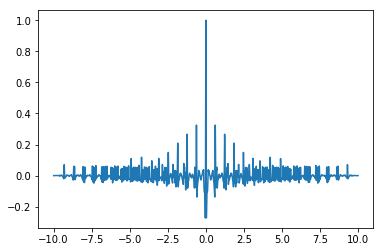

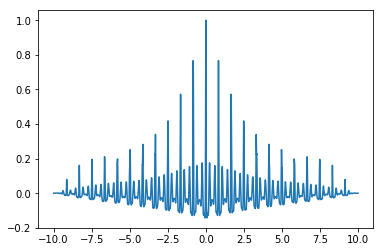

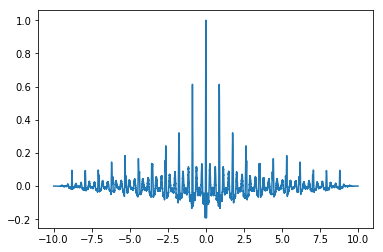

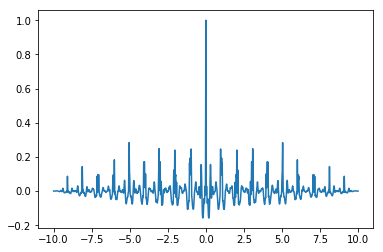

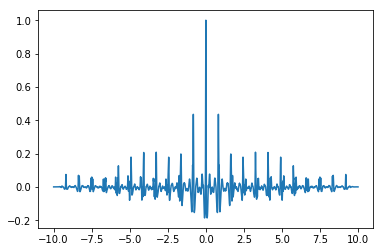

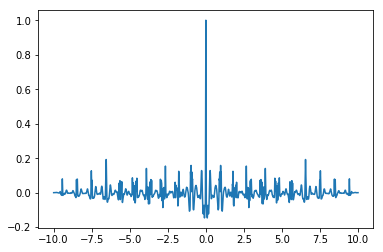

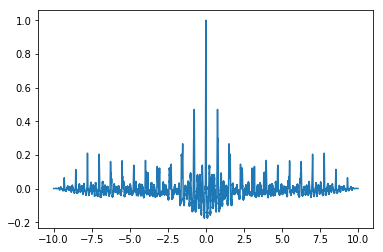

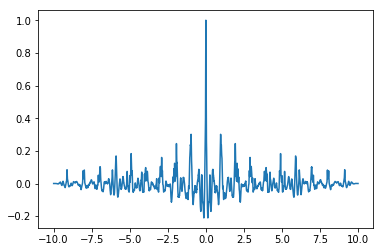

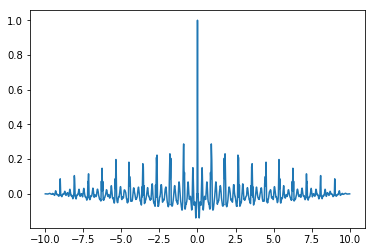

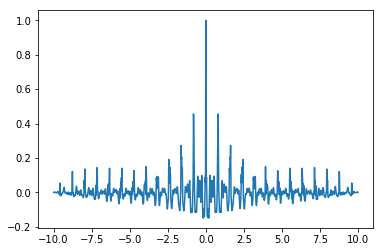

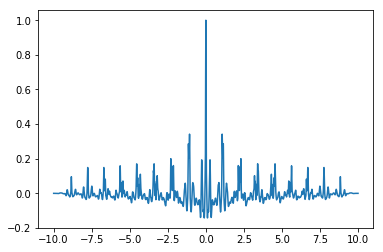

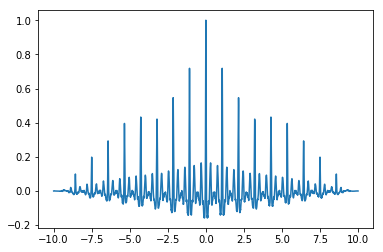

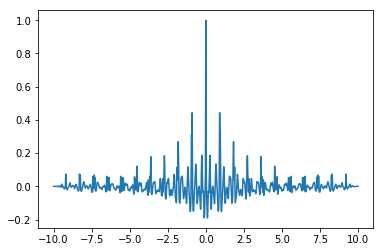

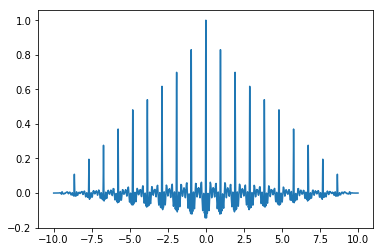

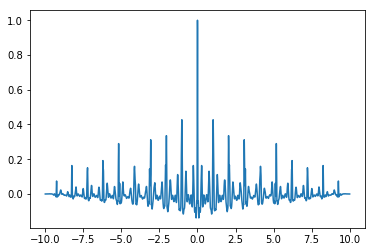

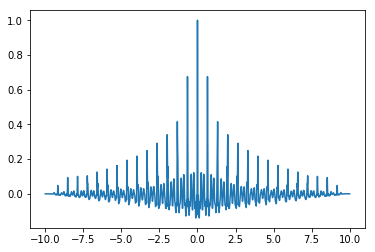

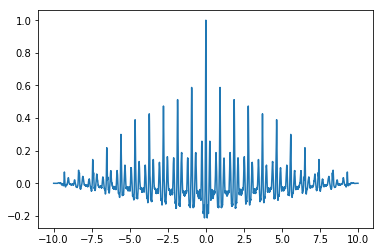

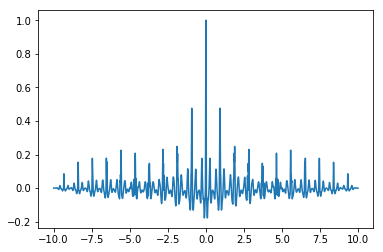

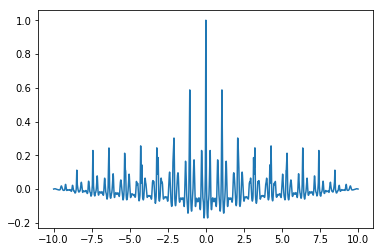

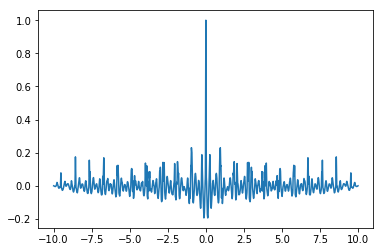

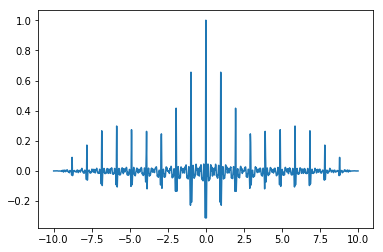

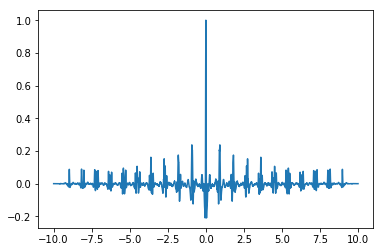

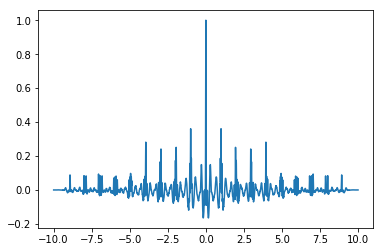

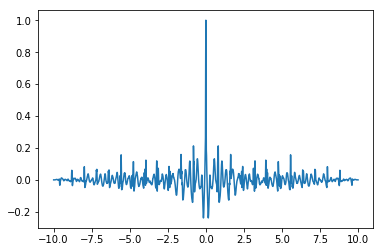

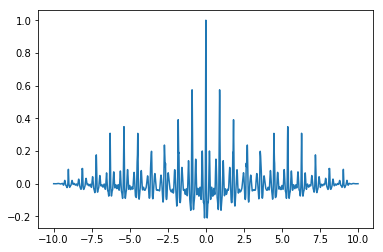

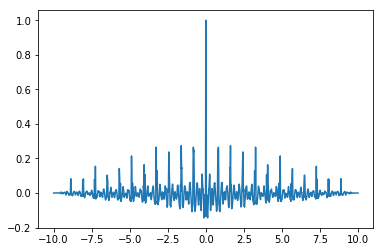

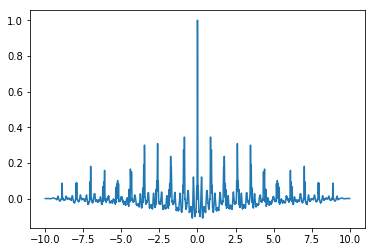

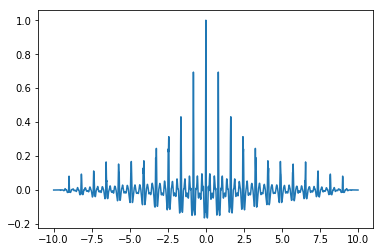

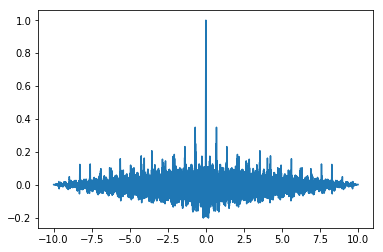

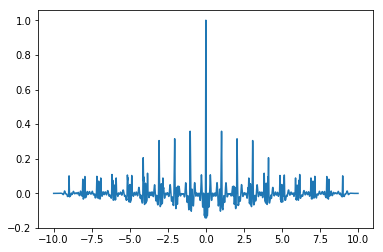

In [10]:
for i in range(30):
    plt.plot(autocorr_t, autocorr_signal[i,0,:])
    plt.show()

In [11]:
def Fourier_transform(freq, time, signal):
    assert isinstance(freq, np.ndarray)
    ft_result = np.zeros(freq.shape, dtype=complex)
    time_diff = np.diff(time)
    signal_diff = np.diff(signal)
    for l in range(len(freq)):
        s = 0
        for k in range(2, len(time)):
            s += (signal_diff[k-1] / time_diff[k-1]) * (cmath.exp(-1j*freq[l]*time[k-1]) - cmath.exp(-1j*freq[l]*time[k]))
        ft_signal = - (freq[l] * 1j + (1 - cmath.exp(- 1j * freq[l] * time[1])) * (signal[1] - 1) / time[1] + s) / freq[l]**2
        ft_result[l] = ft_signal
    return np.multiply(ft_result, freq) * 1j

In [12]:
def cs_oversample(t, signal, factor):
    cs_interpolator = CubicSpline(t, signal)
    num = len(t) * factor
    oversampled_t = np.linspace(0,10,num=num,endpoint=False)
    interpolated_signal = cs_interpolator(oversampled_t)
    return oversampled_t, interpolated_signal

In [ ]:
ft_autocorr_signal = np.zeros((30,8,1000), dtype=complex)
freq = np.array([0.1 * w for w in range(1,1001)])

for i in range(30):
    for j in range(8):
        oversampled_t, interpolated_signal = cs_oversample(t, autocorr_signal[i,j,4999:], 1)
        ft_autocorr_signal[i,j] = Fourier_transform(freq, oversampled_t, interpolated_signal)
        print(str(i)+','+str(j)+'finished')

In [ ]:
a,b = cs_oversample(t, autocorr_signal[0,0,4999:],4)

In [ ]:
Fourier_transform(freq, a, b)

In [ ]:
for i in range(8):
    plt.plot(freq, ft_autocorr_signal[0,i,:].real)
    plt.show()

In [ ]:
for i in range(8):
    plt.plot(freq, ft_autocorr_signal[10,i,:].real)
    plt.show()

In [ ]:
for i in range(8):
    plt.plot(freq, ft_autocorr_signal[20,i,:].real)
    plt.show()

# Finding Optimal Oversampling Factor

In [13]:
def real_ft_exp(freq):
    return (1 - 1j * freq) / (1 + freq ** 2)

In [ ]:
time1 = np.array([0.002 * i for i in range(5000)])
exp1 = np.exp(-1 * time1)

test_freq = np.array([i for i in range(1, 501)])

w = [i for i in range(1,11)]

rae = []

for w in w:
    t, s = cs_oversample(time1, exp1, w)
    ft_exp = Fourier_transform(test_freq, t, s)
    ft_exp_real = real_ft_exp(test_freq)
    diff = np.absolute(ft_exp - ft_exp_real)
    diff = np.divide(diff, np.absolute(ft_exp_real))
    diff = np.sum(diff)
    rae.append(diff)
    print(str(w))
    
plt.plot(w, rae)



1
2
3
